Task 1. Solve classification task

In [2]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

1. Data preparation

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
ds = tfds.load('beans', split='train', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteGBDE3I/beans-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteGBDE3I/beans-validation.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteGBDE3I/beans-test.tfrecord*...:   0%|          | 0/1…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [5]:
ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(500, 500, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [6]:
df = tfds.as_dataframe(ds)

In [7]:
df.head()

,image,label
0,"[[[129, 118, 88], [95, 81, 54], [84, 66, 46], ...",1
1,"[[[149, 132, 106], [141, 124, 98], [134, 118, ...",1
2,"[[[97, 88, 57], [97, 86, 56], [105, 91, 64], [...",1
3,"[[[60, 146, 85], [61, 147, 86], [71, 153, 91],...",0
4,"[[[113, 87, 70], [112, 86, 69], [110, 84, 69],...",0


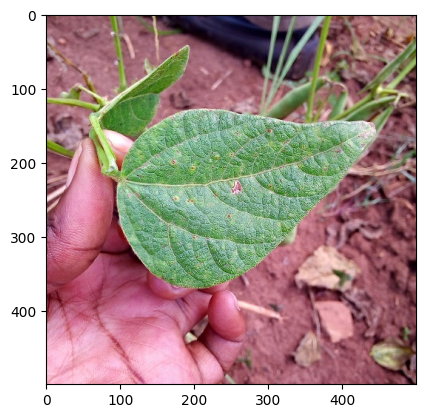

In [8]:
plt.imshow(df['image'][0], cmap='gray')

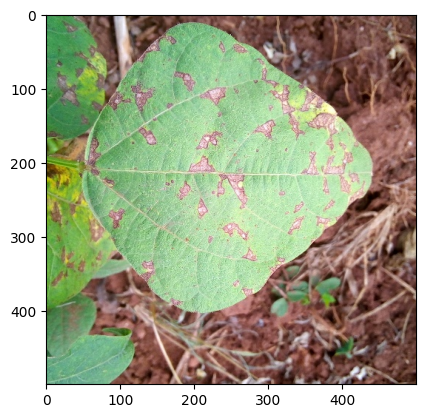

In [9]:
plt.imshow(df['image'][3], cmap='gray')

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(df['image']), np.array(df['label']), test_size=0.2, random_state=10)

In [18]:
print(X_train.dtype)
print(X_test.dtype)
print(y_train.dtype)
print(y_test.dtype)

object
object
int64
int64


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np


X_train = [np.array(img) for img in X_train]
X_test = [np.array(img) for img in X_test]


class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(X_train, y_train, transform=transform)
test_dataset = CustomDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = SimpleCNN(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print('\nClassification Report:')
print(classification_report(all_labels, all_preds))




Test Accuracy: 73.91%

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        61
           1       0.74      0.66      0.70        79
           2       0.78      0.87      0.82        67

    accuracy                           0.74       207
   macro avg       0.74      0.74      0.74       207
weighted avg       0.74      0.74      0.74       207



Baseline accuracy more than 70 for all of classes AND more than 35 for each (7 points)

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test, pred))

from sklearn.metrics import classification_report
print(classification_report(test, pred))


(3 points) Write a function for classification of one image:
<br> Input: 1 image from dataset
<br> Output: predicted class, target class and comparison

In [ ]:
#your code here
def perform_image_classification(image='image'[1]):
    # Preprocess the image
    processed_image = preprocess(image)

    # Obtain predictions from the model
    model_predictions = make_predictions(processed_image)

    # Retrieve the true label for comparison
    true_label = get_true_label(image)

    # Display results
    print("Model Predictions:", model_predictions)
    print("True Label:", true_label)

    # Check if the prediction is correct
    if model_predictions == true_label:
        print("Pred is correct")
    else:
        print("Pred is incorrect")



Theoretical part:
<br>1)Describe your steps if you are using a dataset that does not have enough training data. (3p)
<br>2)Describe difference between BCE, MSE and Cross Entropy (2p)

In [ ]:
'''
1Task
1.examine the dataset-szie,distrubution,potential
2.data augmentation-rotation,horizontalflip,tensor etc all in compose
3. implement transfer learning or use fine tuning for small pics/assume model
4.update model with feature engineering/ add or extract features
5.after regularization like overfitting-relu,dropuot etc
6.evaluate and iterate the code

2Task
BCE
-sigmoid activation
-binary classf
-measure difference between binary and predicted values

MSE
-regression issues
-no specific activation on layer
-ave sqr diffrence between original and predicted

Cross Entropy
-multiclass classification
-softmax activation
-calculate dissimilarities between pred and orig values
'''